# Pre-Processing

In [27]:
# Import necessary packages
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

### Load and create dataframe to pre-process

In [28]:
# Load data and check which columns are identifier columns
df = pd.read_csv('MetacriticGameReviewsClean.csv', index_col=0)
print(df.columns)

# Change the genre of shoot to shooter
df['genre'] = df.genre.replace('Shoot', 'Shooter')

Index(['title', 'platform', 'metascore', 'metasentiment', 'average_userscore',
       'average_usersentiment', 'developer', 'genre', 'number_of_players',
       'esrb_rating', 'release_date', 'username', 'userscore', 'usersentiment',
       'review', 'review_date', 'clean_text', 'language', 'word_count',
       'sentence_count', 'exclamation_count', 'question_count', 'period_count',
       'reading_level', 'syllable_count', 'POS_tagged', 'conjunction_count',
       'adjective_count', 'noun_count', 'pronoun_count', 'adverb_count',
       'verb_count', 'other_POS_count'],
      dtype='object')


### Find best minimum document frequency for count vectorizer
The aim of this project is to predict whether someone is a reviewed a game positively or negatively. The following models were evaluated through grid search cross validation to determine the best performing models with the grading criteria of ‘ROC-AUC’: <br>
- Multinomial Naive Bayes
- Logistic Regression 
- K-nearest Neighbors (KNN)
- Support Vector Machines (SVM)
- Random Forest
- Gradient Boosting <br>

After distinguishing the models with the best performance, the ‘ROC-AUC’ curves for the top two models were plotted. Then, the best model was selected to determine different thresholds for predicting on unseen data.

In [31]:
# Instantiate X variable as the reviews and y as target values, where negative and mixed reviews
# will both be considered as negative reviews
X = df.clean_text
y = df.usersentiment.replace(['negative','mixed','positive'],[0,0,1])

# Split X and y into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Instatiate vectorizer object and tfidf transformer
cv = CountVectorizer()
tfidf = TfidfTransformer()

In [32]:
# Instatiate model
multiNB = MultinomialNB()

# Setup the steps for a pipeline
steps = [('cv', cv),
         ('tfidf', tfidf),
         ('multiNB', multiNB)]

# Setup the parameters to be determined, minimum document frequency in this case
param_grid = [{'cv__min_df': [2,3,5,7,10]}]

# Instatiate pipeline
pipeline = Pipeline(steps)

# Create grid search cross validation pipeline classifier with scoring roc-auc
clf = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='roc_auc')

# Train classifier
clf.fit(X_train, y_train)

# Print the tuned parameters and score
print("Best min_df parameter for the MultinomialNB classifier is {}".format(clf.best_params_)) 
print("Best AUC-ROC score is {}".format(clf.best_score_))

Best min_df parameter for the MultinomialNB classifier is {'cv__min_df': 2}
Best AUC-ROC score is 0.9001948684351909


In [33]:
# Instatiate model
logreg = LogisticRegression()

# Setup the steps for a pipeline
steps = [('cv', cv),
         ('tfidf', tfidf),
         ('logreg', logreg)]

# Setup the parameters to be determined, minimum document frequency in this case
param_grid = [{'cv__min_df': [2,3,5,7,10]}]

# Instatiate pipeline
pipeline = Pipeline(steps)

# Create grid search cross validation pipeline classifier with scoring roc-auc
clf = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='roc_auc')

# Train classifier
clf.fit(X_train, y_train)

# Print the tuned parameters and score
print("Best min_df parameter for the Logistic Regression classifier is {}".format(clf.best_params_)) 
print("Best AUC-ROC score is {}".format(clf.best_score_))

Best min_df parameter for the Logistic Regression classifier is {'cv__min_df': 2}
Best AUC-ROC score is 0.9236704379817423


In [34]:
# Instatiate model
knn = KNeighborsClassifier()

# Setup the steps for a pipeline
steps = [('cv', cv),
         ('tfidf', tfidf),
         ('knn', knn)]

# Setup the parameters to be determined, minimum document frequency in this case
param_grid = [{'cv__min_df': [2,3,5,7,10]}]

# Instatiate pipeline
pipeline = Pipeline(steps)

# Create grid search cross validation pipeline classifier with scoring roc-auc
clf = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='roc_auc')

# Train classifier
clf.fit(X_train, y_train)

# Print the tuned parameters and score
print("Best min_df parameter for the KNN classifier is {}".format(clf.best_params_)) 
print("Best AUC-ROC score is {}".format(clf.best_score_))

Best min_df parameter for the KNN classifier is {'cv__min_df': 5}
Best AUC-ROC score is 0.5214909105638259


In [35]:
# Instatiate model
svc = LinearSVC()

# Setup the steps for a pipeline
steps = [('cv', cv),
         ('tfidf', tfidf),
         ('svc', svc)]

# Setup the parameters to be determined, minimum document frequency in this case
param_grid = [{'cv__min_df': [2,3,5,7,10]}]

# Instatiate pipeline
pipeline = Pipeline(steps)

# Create grid search cross validation pipeline classifier with scoring roc-auc
clf = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='roc_auc')

# Train classifier
clf.fit(X_train, y_train)

# Print the tuned parameters and score
print("Best min_df parameter for the linear SVC classifier is {}".format(clf.best_params_)) 
print("Best AUC-ROC score is {}".format(clf.best_score_))

Best min_df parameter for the linear SVC classifier is {'cv__min_df': 2}
Best AUC-ROC score is 0.9189967715581048


In [36]:
# Instatiate model
rf = RandomForestClassifier()

# Setup the steps for a pipeline
steps = [('cv', cv),
         ('tfidf', tfidf),
         ('rf', rf)]

# Setup the parameters to be determined, minimum document frequency in this case
param_grid = [{'cv__min_df': [2,3,5,7,10]}]

# Instatiate pipeline
pipeline = Pipeline(steps)

# Create grid search cross validation pipeline classifier with scoring roc-auc
clf = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='roc_auc')

# Train classifier
clf.fit(X_train, y_train)

# Print the tuned parameters and score
print("Best min_df parameter for the Random Forest classifier is {}".format(clf.best_params_)) 
print("Best AUC-ROC score is {}".format(clf.best_score_))

Best min_df parameter for the Random Forest classifier is {'cv__min_df': 3}
Best AUC-ROC score is 0.8991802453453606


In [37]:
# Instatiate model
gb = GradientBoostingClassifier()

# Setup the steps for a pipeline
steps = [('cv', cv),
         ('tfidf', tfidf),
         ('gb', gb)]

# Setup the parameters to be determined, minimum document frequency in this case
param_grid = [{'cv__min_df': [2,3,5,7,10]}]

# Instatiate pipeline
pipeline = Pipeline(steps)

# Create grid search cross validation pipeline classifier with scoring roc-auc
clf = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='roc_auc')

# Train classifier
clf.fit(X_train, y_train)

# Print the tuned parameters and score
print("Best min_df parameter for the Gradient Boosting classifier is {}".format(clf.best_params_)) 
print("Best AUC-ROC score is {}".format(clf.best_score_))

Best min_df parameter for the Gradient Boosting classifier is {'cv__min_df': 7}
Best AUC-ROC score is 0.8660575935331325


With just terms as predictors the Logistic Regression and SVC models performed the best with above 90% area under curve and using a count vectorizer with a minimum document frequency of 2. These models were furthered tested with all features and different inverse of regularization strength values.

### Find the best inverse of regularization strength value for top two models

In [63]:
# Instantiate count vectorizer with minimum df of 2, the best parameter for the top two perfoming,
# and max features of 10000 to make the computation less exhaustive to the pc
cv = CountVectorizer(min_df=2)

# Setup a pipeline to process term features for the clean text
pipe = Pipeline([('cv', cv),
                 ('tfidf', tfidf)]).fit(df.clean_text)

# Retrieve the best term predictors
tfidf_terms = pipe.transform(df.clean_text)

# Split new predictors and target variable into new test and train sets
X = tfidf_terms
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [70]:
# Instantiate different values for the inverse regularization strentgh parameter for grid search
C = [0.001, 0.01, 0.1, 1]

# Instantiate the model
logreg = LogisticRegression()

# Setup the parameter grid
param_grid = {'C': C}

# Create grid search cross validation pipeline classifier with scoring roc-auc
lr_clf = GridSearchCV(logreg, param_grid=param_grid, cv=3, scoring='roc_auc')

# Train the classifier
lr_clf.fit(X_train, y_train)

# Print the tuned parameters and score
print("Best min_df parameter for the Logistic Regression classifier is {}".format(lr_clf.best_params_)) 
print("Best AUC-ROC score is {}".format(lr_clf.best_score_))

Best min_df parameter for the Logistic Regression classifier is {'C': 1}
Best AUC-ROC score is 0.9203827173184292


In [82]:
# Instantiate the model
svc = LinearSVC()

# Create grid search cross validation pipeline classifier with scoring roc-auc
svc_clf = GridSearchCV(svc, param_grid=param_grid, cv=3, scoring='roc_auc')

# Train the classifier
svc_clf.fit(X_train, y_train)

# Print the tuned parameters and score
print("Best min_df parameter for the linear SVC classifier is {}".format(svc_clf.best_params_)) 
print("Best AUC-ROC score is {}".format(svc_clf.best_score_))

Best min_df parameter for the linear SVC classifier is {'C': 0.1}
Best AUC-ROC score is 0.9206108512350798


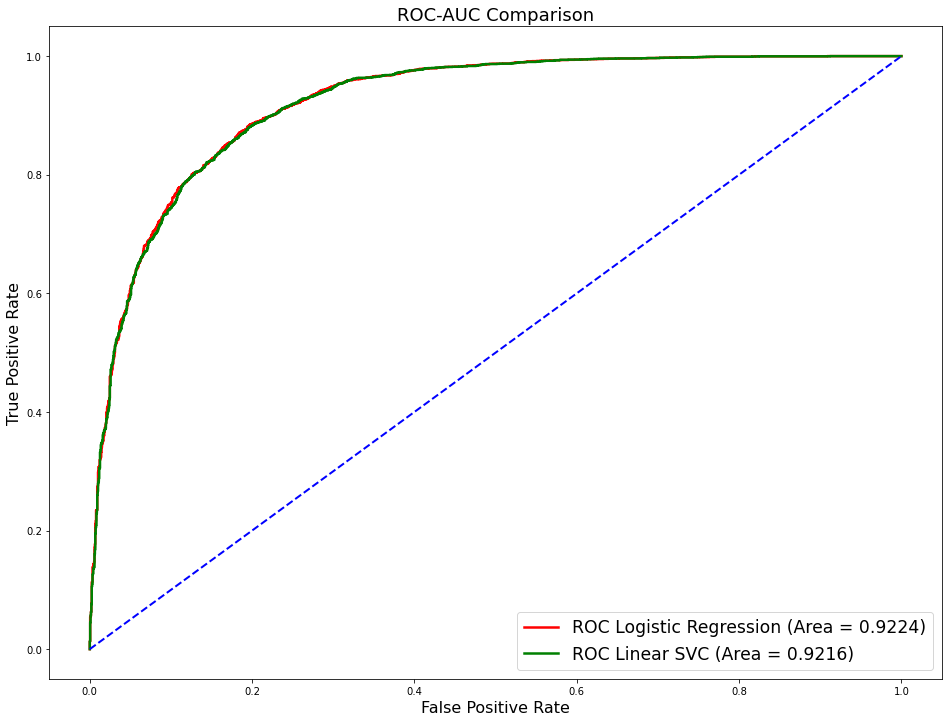

In [93]:
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
%matplotlib inline

# Create and train the models with the best parameters
lr = LogisticRegression(C=1)
lr.fit(X_train, y_train)
svc = CalibratedClassifierCV(LinearSVC(C=0.1))
svc.fit(X_train, y_train)

# Generate false and true positive rates for best performing models to plot ROC curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
lr_auc = auc(lr_fpr, lr_tpr)
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc.predict_proba(X_test)[:,1])
svc_auc = auc(svc_fpr, svc_tpr)

# Compare ROC-AUC curves to choose best model
plt.figure(figsize=(16,12))
plt.plot(lr_fpr, lr_tpr, linewidth=2.5, label='ROC Logistic Regression (Area = %0.4f)' %lr_auc, color='red')
plt.plot(svc_fpr, svc_tpr, linewidth=2.5, label='ROC Linear SVC (Area = %0.4f)' %svc_auc, color='green')
plt.plot([0,1], [0,1], linewidth=2, linestyle='--', color='blue')
plt.legend(loc=4, fontsize='xx-large')
plt.title('ROC-AUC Comparison', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.show()

The performance between the two models is almost indistinguishable. The Logistic Regression model just barely outperforms the Linear SVC by about 0.08% area under curve. Going forward the Logisitic Regression model is used for thresholding optimization.

### Evaluate the best performing model
To accurately depict how a gamer actually felt about a game both the number of false positives and false negatives should be minimized. Therefore, a beta of 1 for the f metric was used to find the threshold that optimized for both precision and recall. With a beta of 1 both precision and recall are weighted equally.

In [106]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

def get_accuracy(model, X_test, y_test, threshold):
    
    y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    
    return([acc, bal_acc])

In [107]:
# Create a threshold dataframe to store values for precision, recall, and f1 score
accuracy_df = pd.DataFrame(columns=['Accuracy','Balanced_Accuracy'])

# Loop over different thresholds to evaluate which yields the most optimal results
for threshold in np.arange(0.1,.9,.02):
    y_pred
    accuracy_df.loc[threshold] = get_accuracy(lr, X_test, y_test, threshold)

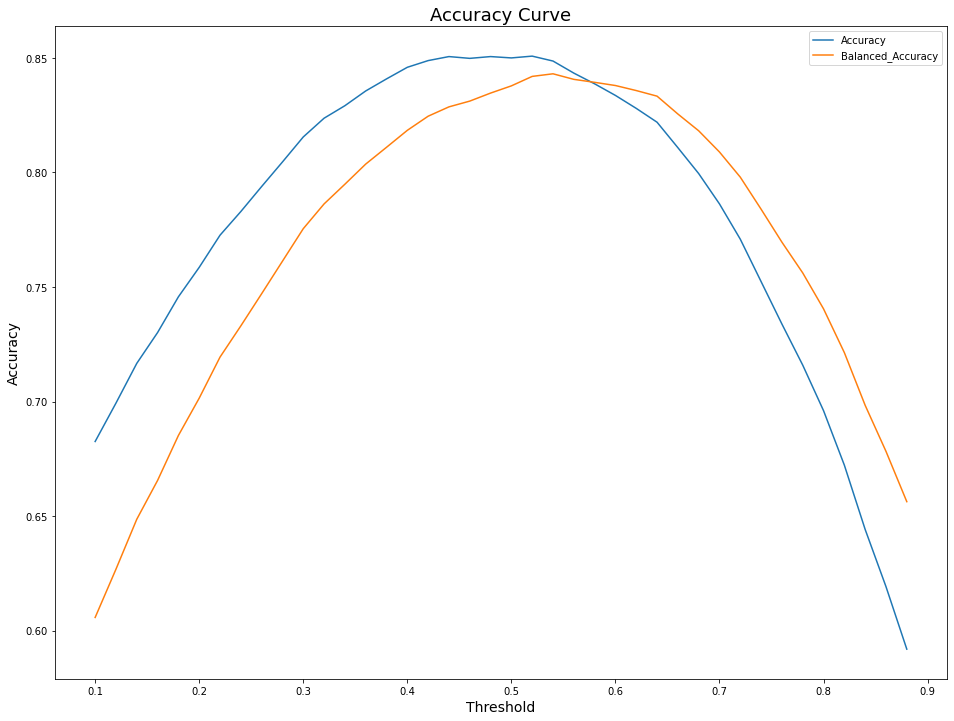

In [108]:
# Plot precision-recall values at different thresholds
accuracy_df.plot(figsize=(16,12))
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy Curve', fontsize=18)
#plt.axvline(0.35, color='black', alpha=0.5)
#plt.text(0.335, 0.305, 'Threshold for Positive Reviews', rotation=90, alpha=0.8, fontsize=16)
#plt.axvline(0.8, color='black', alpha=0.5)
#plt.text(0.785, 0.305, 'Threshold for Negative Reviews', rotation=90, alpha=0.8, fontsize=16)
#plt.axvline(0.5, color='black', alpha=0.5)
#plt.text(0.485, 0.305, 'Default Threshold', rotation=90, alpha=0.8, fontsize=16)
plt.show()

In [74]:
# Precision, recall, fscore function retrieved from https://github.com/ithisted/PetAdoptionPrediction/blob/master/PetAdoptionPrediction.ipynb
from sklearn.metrics import fbeta_score

def precision_recall(model, X_test, y_test, threshold, beta = 1):
    
    y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    matrix = confusion_matrix(y_test, y_pred)
    
    tn = matrix[0,0] 
    tp = matrix[1,1] 
    fp = matrix[0,1] 
    fn = matrix[1,0] 
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    f_beta = fbeta_score(y_test, y_pred, beta=beta)
    
    return([precision, recall, f_beta])

In [94]:
# Create a threshold dataframe to store values for precision, recall, and f1 score
threshold_df = pd.DataFrame(columns=['Precision','Recall','F1_measure'])

# Loop over different thresholds to evaluate which yields the most optimal results
for threshold in np.arange(0.1,.9,.02):
    threshold_df.loc[threshold] = precision_recall(lr, X_test, y_test, threshold)

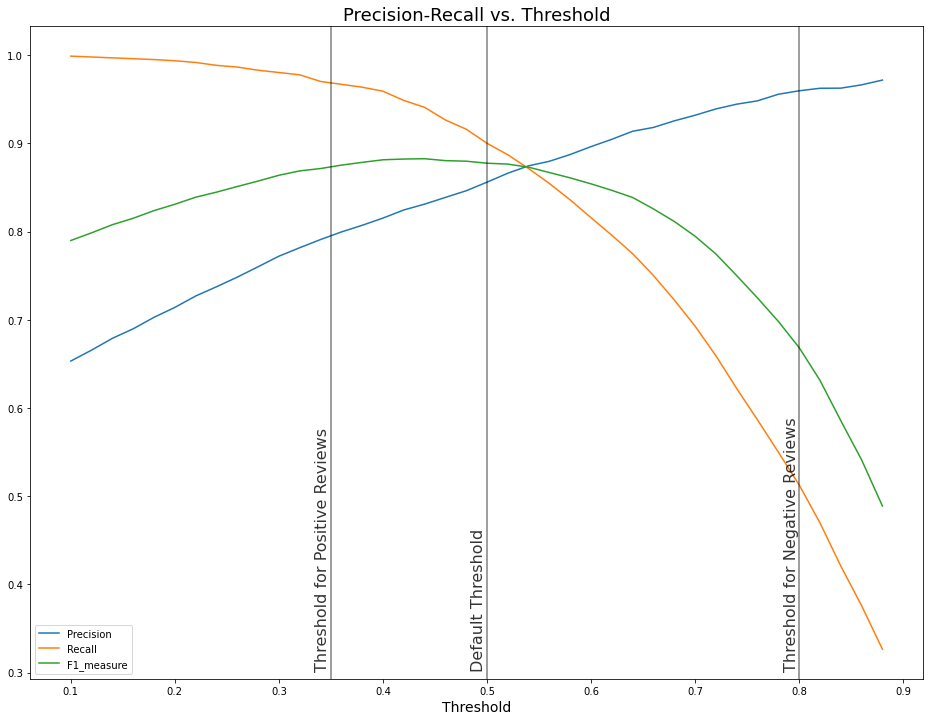

In [104]:
# Plot precision-recall values at different thresholds
threshold_df.plot(figsize=(16,12))
plt.xlabel('Threshold', fontsize=14)
plt.title('Precision-Recall vs. Threshold', fontsize=18)
plt.axvline(0.35, color='black', alpha=0.5)
plt.text(0.335, 0.305, 'Threshold for Positive Reviews', rotation=90, alpha=0.8, fontsize=16)
plt.axvline(0.8, color='black', alpha=0.5)
plt.text(0.785, 0.305, 'Threshold for Negative Reviews', rotation=90, alpha=0.8, fontsize=16)
plt.axvline(0.5, color='black', alpha=0.5)
plt.text(0.485, 0.305, 'Default Threshold', rotation=90, alpha=0.8, fontsize=16)
plt.show()

In [47]:
# Confusion matrix function retrieved from https://github.com/DTrimarchi10/confusion_matrix
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,    
                          figsize=None,
                          fontsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories,annot_kws={"size": fontsize})

    if xyplotlabels:
        plt.ylabel('True label', fontsize=fontsize)
        plt.xlabel('Predicted label' + stats_text, fontsize=fontsize)
    else:
        plt.xlabel(stats_text, fontsize=fontsize)
    
    if title:
        plt.title(title, fontsize=fontsize)

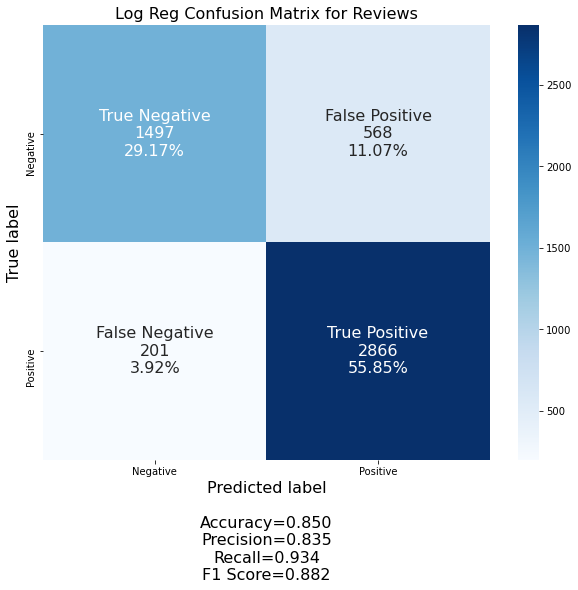

In [105]:
# Generate predicted y values for the test set
y_pred = (lr.predict_proba(X_test)[:,1] >= 0.45).astype(bool)

# Create confusion matrix for y test values versus predicted y values using the determined threshold
group_names = ['True Negative','False Positive','False Negative','True Positive']
categories = ['Negative','Positive']
cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix,group_names=group_names,categories=categories,fontsize=16,figsize=(10,8),cmap='Blues',title='Log Reg Confusion Matrix for Reviews')

The logistic regression model developed performed exceptionally well on the test set, only 1 test case was misclassifed as a false negative (a positive review classified as negative). Using the model all cases in the data were predicted on and the misclassifications were examined.

### Examine the misclassified reviews

In [97]:
# Add new column of predicted user sentiments by the Logistic Regression model
df['usersentiment_predicted'] = lr.predict(X)

# Check the value counts of all user sentiment as sanity check when looking at misclassifications
df.usersentiment.value_counts()

positive    11910
negative     5069
mixed        3549
Name: usersentiment, dtype: int64

In [98]:
# Collect all negative and mixed reviews to double check none were predicted as positive
neg_reviews = df[df.usersentiment != 'positive'].loc[:,['title','usersentiment_predicted','review']]
neg_reviews.usersentiment_predicted.value_counts()

0    7178
1    1440
Name: usersentiment_predicted, dtype: int64

In [102]:
# Collect all positive reviews and check which were misclassified
pos_reviews = df[df.usersentiment == 'positive'].loc[:,['title','review','usersentiment', 'usersentiment_predicted']]
misclassifications = pos_reviews[pos_reviews.usersentiment_predicted == 0].head()

# Print out misclassified reviews
for rev in misclassifications.review:
    print(rev, '\n')

grand theft auto five is a okay game it is not my personal favorite. i don't feel it is worth fifty pounds the online was a disappointment  i feel after spending five years on a game it could of been much better than it was. the story line was good i enjoyed playing it i feel having three playable characters was a good ideas therefore i feel it was overall a goodish game. 

Metal Gear Solid The Phantom Pain is a great game however falls short as a perfect game Where the game-play mechanics can be argued as being unparalleled by any other stealth based game or any 3rd person shooter at the matter, game-play follows pretty similarly to the games predecessor, Ground Zeros. However in saying this the phantom pain offers a more refined approach to this with controls feeling smoother and well implemented. Game-play is also a more noticeable challenge with players getting spotted easier and dying faster stressing the games need for player based strategy The free-rooming aspect is another fant

After reading over the misclassified reviews, trends observed in the EDA portion of the project presented themselves in two of these reviews. The first review may have been classified due to the many misspelled words it contained. In the second review, the reviewer summarizes how others rated the game with a few negative words. There are also a few sentences where the reviewer explained their own discontent with the game, perhaps contributing to the misclassification. In the last review, the reviewer mentions price throughout their review. Money is a predictive word of negative reviews, the reviewer also uses repetitive, decent and dissapointment words predictive of mixed reviews which were treated as negative for the purpose of making the model a binary classifier.